# Group Project - 2

| Sl.no | Team Member | UT EID |
|---	| ------	|---	|
| 1 | Chyavan Mysore Chandrashekar 	| CM65624 |
| 2 | Mihir Ninad Deshpande       	|  |
| 3 | Neel Sheth        	        |  |
| 4 | Tanushree Devi Balaji       	|  |

<hr>

### Imports Required

In [1]:
import gurobipy as gp
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

### Stock Portfolio class
Stock Portfolio Class has been defined that can handle two types of optimization.
* First Method - Use a correlation matrix to find the optimal `m` subset of stocks from the 100 stocks that can best represent the other `100-m` stocks. Then, find the optimal way to weigh each of these stocks in the portfolio being created so as to match the Index performance as much as possible.
* Second Method - Consider a single Mixed Integer Program (`MIP` in code) where we directly find the optimal weights for `m` subset of stocks, making sure that the other weights are zero.

In [2]:
class StockPortfolio:
    """
    Methods:
        __init__: Initializes the StockPortfolio object with the Training data to be taken from the "filepath" passed,
            and uses the solver as mentioned in the argument
        
        __get_returns__: Private method to create the return DataFrame from the stock price DataFrame

        build_portfolio: Public method to build a portfolio of "m" stocks based on the data in "filepath""Project-2 copy.ipynb"

        get_error: Get the *difference in the performance of the portfolio with the Index fund on the given data.
            * Difference in performance is measured as the Sum Absolute Difference between the returns of the index and the portfolio
                over the time available in the data
    """
    def __init__(self, filepath, MIP=False):
        """
        Parameters:
            - filepath: str
                file path of the dataset with the stocks on which the stocks and weights have to be determined (i.e. Training Data)
            - MIP: bool, default False
                True if the class has to use Mixed Integer Program (second method) to solve a single optimization problem
                and find the optimal stocks
        
        Returns:
            None
        """
        self.filepath = filepath
        self.MIP = MIP
        stock_df = pd.read_csv(self.filepath)

        # First Column is considered as the date column, and second columns is considered as the Index Fund column
        # - Alternatively, we can hardcode column with name "X" and "NDX" to be the date and Index Fund columns
        self.date_col = stock_df.columns.values[0]
        self.idx_fund_col = stock_df.columns.values[1]

        # Make date as the index of the dataframe
        stock_df[self.date_col] = pd.to_datetime(stock_df[self.date_col])
        stock_df.set_index(keys=self.date_col, inplace=True)
        stock_df.sort_index(inplace=True)

        # Calculate the returns dataframe - This dataframe will have one less row than the original dataframe
        self.returns_df = pd.DataFrame(0, index=stock_df.index.values[1:], columns=stock_df.columns.values)
        self.returns_df = self.returns_df.apply(
            func=lambda row: self.__get_returns__(stock_df, row.name), axis=1
        )

        # Calculate the Correlation Matrix between the stocks using the returns
        correlation_df = self.returns_df.corr()

        # Make copies to store data of all stocks except "Index"
        self.no_idx_returns_df = self.returns_df.drop(columns=self.idx_fund_col)
        self.no_idx_correlation_df = correlation_df.drop(columns=self.idx_fund_col).drop(self.idx_fund_col)

        # Calculate the number of rows and columns (#stocks)
        self.n_rows = self.no_idx_correlation_df.shape[0]
        self.n_cols = self.no_idx_correlation_df.shape[1]
        self.selected_stocks = None

    def __get_returns__(self, price_df, day):
        """
        Parameters:
            - price_df: pandas.DataFrame
                A DataFrame containing the prices of all the stocks
            - day: pandas.Timestamp
                The day (row) of the DataFrame to calculate the returns on as compared to the previous day

        Returns:
            - pandas.Series
                A series of returns calculated for all the stocks for the particular day
        """
        today = day
        yesterday = price_df.index[price_df.index.tolist().index(day) - 1]
        return (price_df.loc[today] - price_df.loc[yesterday])/price_df.loc[yesterday]

    def build_portfolio(self, m, time_secs=3600):
        """
        Parameters:
            - m: int
                The number of stocks to be selected from the list of stocks present in the DataFrame to create the portfolio
            - time_secs: int, Default = 3600
                The number of seconds the optimizer should run for after which the sub-optimal solution should be returned

        Returns:
            - pandas.DataFrame
                A DataFrame with Indices representing the portfolio stocks,
                and the column "weight" representing its weight in the portfolio 
        """

        # Create an array to make it easy for indexing the "A" matrix later
        arr_cols = np.array(range(self.n_cols))

        # We need to solve for the best "m" stocks representing all the stocks among the 100 stocks
        #   only for the first method
        if not self.MIP:

            # Define the number of constraints, variables, matrices - A,b, sense, obj
            n_constraints = 1 + self.n_rows + self.n_rows*self.n_cols
            n_variables = self.n_cols + self.n_rows*self.n_cols
            A = np.zeros((n_constraints, n_variables))
            sense = np.array(['=']*n_constraints)
            b = np.array([0]*n_constraints)
            constraints_added = 0

            # Make correlation matrix linear 1-D Array
            correlation_linear = []
            for i in self.no_idx_correlation_df.columns:
                correlation_linear += self.no_idx_correlation_df[i].to_list()
            obj = np.array([0]*self.n_cols + correlation_linear)

            # Constraint to select a max of "m" stocks
            A[constraints_added, :self.n_cols] = 1
            b[constraints_added] = m
            constraints_added += 1

            # Constraints to have only one representative stock for each stock in the portfolio
            for i in range(self.n_rows):
                A[constraints_added, self.n_cols+i*self.n_rows+arr_cols] = 1
                b[constraints_added] = 1
                constraints_added += 1

            # Logical constraint for each x to be non-zero when the representative stock is present in the portfolio
            for i in range(self.n_rows):
                for j in range(self.n_cols):
                    A[constraints_added, self.n_cols*(1+i) + j] = 1
                    A[constraints_added, j] = -1
                    b[constraints_added] = 0
                    sense[constraints_added] = '<'
                    constraints_added += 1

            # Optimize
            ojModel = gp.Model()
            ojModX = ojModel.addMVar(len(obj), vtype=['B']*len(obj))
            ojModel.addMConstrs(A, ojModX, sense, b)
            ojModel.setMObjective(None, obj, 0, sense=gp.GRB.MAXIMIZE)
            ojModel.Params.OutputFlag = 0
            ojModel.optimize()

            # Save selected stock array (A binary array with 1 if the stock is present in the portfolio, else 0)
            self.selected_stocks = ojModX.x[:self.n_cols]

        # Second Optimization - This step is required for both methods with additional constraints for the second method
        
        # Define the number of constraints, variables, matrices - A,b, sense, obj, vtype
        n_weights = self.n_cols if self.MIP else m
        n_variables = n_weights + len(self.returns_df)
        n_constraints = 1 + 2*len(self.returns_df)
        
        # Modify variables based on the type of solver being used
        if self.MIP:
            portfolio = self.no_idx_returns_df
            n_variables += self.n_cols
            n_constraints += self.n_cols + 1
        else:
            portfolio = self.no_idx_returns_df[self.no_idx_returns_df.columns[self.selected_stocks.astype(bool)]]
        index_fund = self.returns_df[[self.idx_fund_col]]
        
        A = np.zeros((n_constraints, n_variables))
        sense = np.array(['>']*n_constraints)
        b = np.array([0.]*n_constraints)
        constraints_added = 0
        obj = np.array([0]*n_weights + [1]*len(self.returns_df) + [0]*int(self.MIP)*self.n_cols)
        vtype = np.array(['C']*n_weights + ['C']*len(self.returns_df) + ['B']*int(self.MIP)*self.n_cols)

        # Constraint to limit the sum of weights to 100%
        A[constraints_added, :n_weights] = 1
        b[constraints_added] = 1
        sense[constraints_added] = '='
        constraints_added += 1

        # Constraint for the minimization of absolute error
        for i in range(len(portfolio)):
            # First half of absolute value constraint
            A[constraints_added, n_weights+i] = 1
            A[constraints_added, :n_weights] = portfolio.iloc[i].values
            b[constraints_added] = index_fund.iloc[i]
            constraints_added += 1

            # Second half of absolute value constraint
            A[constraints_added, n_weights+i] = 1
            A[constraints_added, :n_weights] = -portfolio.iloc[i].values
            b[constraints_added] = -index_fund.iloc[i]
            constraints_added += 1
        
        # Adding extra constraints for the second method
        if self.MIP:
            # Logical Constraints (Big M constraints) for the weights to be non-zero only when stock is picked 
            for i in range(self.n_cols):
                A[constraints_added, i] = 1
                A[constraints_added, self.n_cols + len(self.returns_df) + i] = -1
                b[constraints_added] = 0
                sense[constraints_added] = '<'
                constraints_added += 1

            # Making sure only "m" among all stocks are selected for the portfolio
            A[constraints_added, self.n_cols + len(self.returns_df):] = 1
            b[constraints_added] = m
            sense[constraints_added] = '='
            constraints_added += 1

        # Optimize the weights
        ojModel = gp.Model()
        ojModX = ojModel.addMVar(len(obj), vtype=vtype)
        ojModel.addMConstrs(A, ojModX, sense, b)
        ojModel.setMObjective(None, obj, 0, sense=gp.GRB.MINIMIZE)
        ojModel.Params.OutputFlag = 0
        ojModel.Params.TimeLimit = time_secs
        ojModel.optimize()

        # Save the weights obtained as an attribute of the class
        self.weights = ojModX.x[:n_weights]

        # Return a dataframe with Indices representing the portfolio stocks,
        #   and the column "weight" representing its weight in the portfolio
        return pd.DataFrame(ojModX.x[:n_weights], columns=["weight"], index=portfolio.columns)

    def get_error(self, test_filepath=None):
        """
        Parameters:
            - test_filepath: str, Default=None
                file path of the dataset with the stocks on which the performance of the portfolio has to be evaluated (i.e. Test Data).
                If nothing is passed, the error will be calculated on the same data the portfolio was obtained on (i.e. Training Data)
        
        Returns:
            Sum Absolute Difference between the returns of the index and the portfolio over the time available in the data
        """

        if type(test_filepath) == type(None):
            test_filepath = self.filepath

        # Read and format the data as a DataFrame
        test_df = pd.read_csv(test_filepath)
        test_df[self.date_col] = pd.to_datetime(test_df[self.date_col])
        test_df.set_index(keys=self.date_col, inplace=True)
        test_df.sort_index(inplace=True)

        # Calculate the returns from the prices of the stocks in the DataFrame
        test_returns_df = pd.DataFrame(0, index=test_df.index.values[1:], columns=test_df.columns.values)
        test_returns_df = test_returns_df.apply(
            func=lambda row: self.__get_returns__(test_df, row.name), axis=1
        )

        # Keep a copy of the returns DataFrame without the Index fund column
        test_no_idx_returns_df = test_returns_df.drop(columns=self.idx_fund_col)

        # Select the portfolio based on the type of solver
        #   - If MIP is used, portfolio is basically all stocks, but weights are non-zero only for "m" of them
        if self.MIP:
            portfolio = test_no_idx_returns_df
        else:
            portfolio = test_no_idx_returns_df[self.no_idx_returns_df.columns[self.selected_stocks.astype(bool)]]
        index_fund = test_returns_df[[self.idx_fund_col]]
        
        # Calculate the Sum Absolute Error between the portfolio and index fund, and return the same
        error = 0
        for i in range(len(portfolio)):
            error += np.abs(
                np.dot(portfolio.iloc[i].values, self.weights) - index_fund.iloc[i, 0]
            )
        return error

### Finding the 5 best stocks to include in the portfolio

In [69]:
portfolio_obj = StockPortfolio("stocks2019.csv", MIP=False)
portfolio = portfolio_obj.build_portfolio(5)

print("Portfolio of 5 stocks (with the weights as percentages)")
(portfolio*100).round(2)

Portfolio of 5 stocks (with the weights as percentages)


,weight
LBTYK,4.89
MXIM,21.04
MSFT,58.04
VRTX,7.12
XEL,8.92


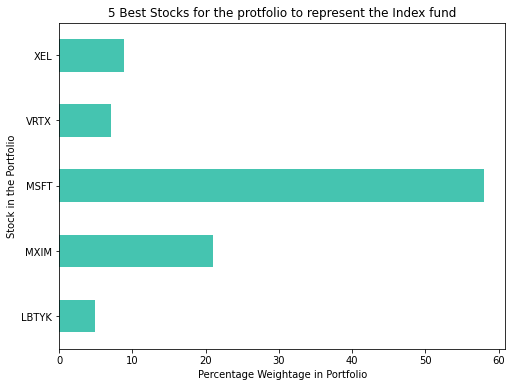

In [70]:
(portfolio*100).plot.barh(y="weight", color='#45C4B0', legend=None, figsize=(8, 6))
plt.title("5 Best Stocks for the protfolio to represent the Index fund")
plt.xlabel("Percentage Weightage in Portfolio")
plt.ylabel("Stock in the Portfolio")
plt.show()

### Performance of the Stocks

#### 1. In 2019

Sum Absolute Difference of the returns (in %) between the Index fund and the 5 stocks in the portfolio in 2019.

In [71]:
print("Training Error:", portfolio_obj.get_error())

Training Error: 0.789178282463145


#### 2. In 2020

Sum Absolute Difference of the returns (in %) between the Index fund and the 5 stocks in the portfolio in 2020.

In [72]:
print("Test Error:", portfolio_obj.get_error(test_filepath='stocks2020.csv'))

Test Error: 0.8696699433741913


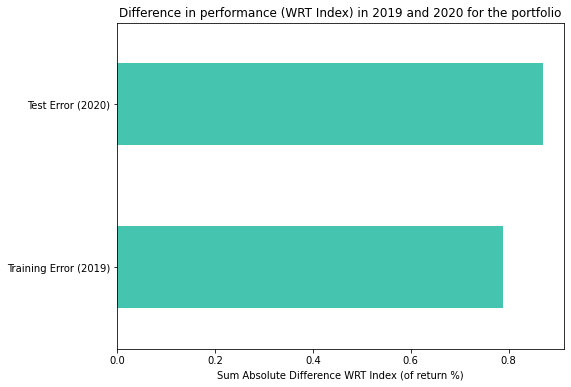

In [73]:
pd.DataFrame([
        portfolio_obj.get_error(),
        portfolio_obj.get_error(test_filepath='stocks2020.csv')],
    index=["Training Error (2019)", "Test Error (2020)"]) \
.plot.barh(color='#45C4B0', legend=None, figsize=(8, 6))
plt.title("Difference in performance (WRT Index) in 2019 and 2020 for the portfolio")
plt.xlabel("Sum Absolute Difference WRT Index (of return %)")
plt.show()

### Performance Evaluation for different values of "m"

In [74]:
errors = pd.DataFrame(
    [], columns=["Training Error", "Test Error", "m", "stock_weights"]
)

for m in range(10,101,10):
    portfolio_obj = StockPortfolio("stocks2019.csv", MIP=False)
    portfolio_weights = portfolio_obj.build_portfolio(m)
    training_error = portfolio_obj.get_error()
    test_error = portfolio_obj.get_error(test_filepath='stocks2020.csv')
    errors.loc[len(errors)] = [training_error, test_error, m, portfolio_weights.to_dict()]
errors.set_index("m", inplace=True)
errors.to_csv("FirstMethodPerformance.csv")

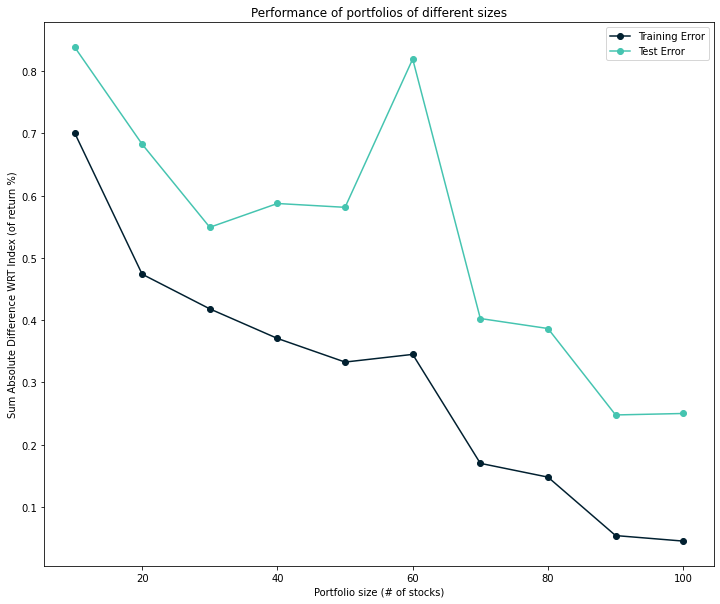

In [75]:
errors.plot(y=["Training Error", "Test Error"], marker="o", figsize=(12,10), color=["#012030", "#45C4B0"])
plt.title("Performance of portfolios of different sizes")
plt.xlabel("Portfolio size (# of stocks)")
plt.ylabel("Sum Absolute Difference WRT Index (of return %)")
plt.show()

### Solving a Single "Mixed Integer Program"

In [76]:
errors_MIP = pd.DataFrame(
    [], columns=["Training Error", "Test Error", "m", "stock_weights"]
)

for m in range(10,101,10):
    portfolio_obj = StockPortfolio("stocks2019.csv", MIP=True)
    portfolio_weights = portfolio_obj.build_portfolio(m, 3600)
    training_error = portfolio_obj.get_error()
    test_error = portfolio_obj.get_error(test_filepath='stocks2020.csv')
    errors_MIP.loc[len(errors_MIP)] = [training_error, test_error, m, portfolio_weights.to_dict()]
errors_MIP.set_index("m", inplace=True)
errors_MIP.to_csv("SecondMethodPerformance.csv")
errors_MIP

,Training Error,Test Error,stock_weights
m,,,
10,0.290137,0.548939,"{'weight': {'ATVI': 0.0, 'ADBE': 0.0, 'AMD': 0..."
20,0.159429,0.416908,"{'weight': {'ATVI': 0.01382051578256075, 'ADBE..."
30,0.107021,0.359760,"{'weight': {'ATVI': 0.0, 'ADBE': 0.02455918617..."
40,0.078739,0.291981,"{'weight': {'ATVI': 0.0, 'ADBE': 0.01797095555..."
50,0.061835,0.249492,"{'weight': {'ATVI': 0.0, 'ADBE': 0.02436270147..."
60,0.051988,0.252797,"{'weight': {'ATVI': 0.0, 'ADBE': 0.01565746146..."
70,0.047567,0.240660,"{'weight': {'ATVI': 0.003493793736035044, 'ADB..."
80,0.045227,0.249143,"{'weight': {'ATVI': 0.0031192740211602316, 'AD..."
90,0.044913,0.250377,"{'weight': {'ATVI': 0.004234168796494505, 'ADB..."


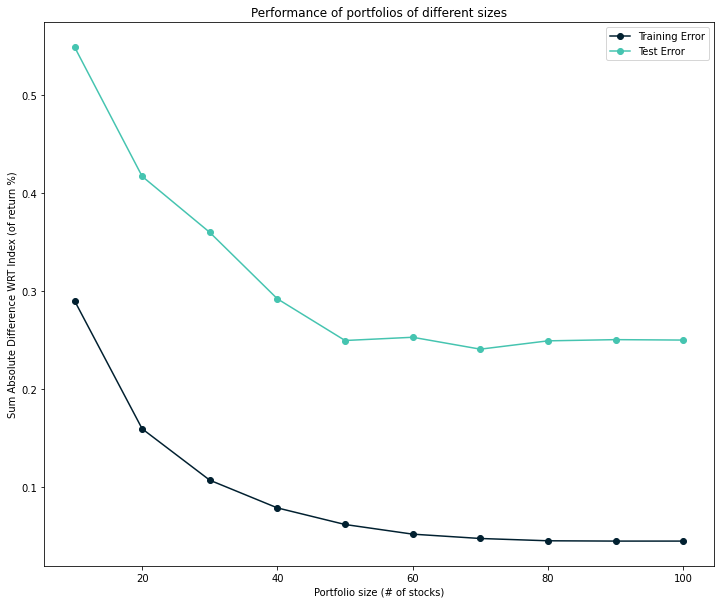

In [77]:
errors_MIP.plot(y=["Training Error", "Test Error"], marker="o", figsize=(12,10), color=["#012030", "#45C4B0"])
plt.title("Performance of portfolios of different sizes")
plt.xlabel("Portfolio size (# of stocks)")
plt.ylabel("Sum Absolute Difference WRT Index (of return %)")
plt.show()